Start with a simple multi-stage autoencoder.

Use pRELU since it should be invertible

https://blog.keras.io/building-autoencoders-in-keras.html

Use LeakyReLU with custom inversion layer. 

Initialize Dense inversions with Penrose pseudo-inverse of matching base layer, but do not force them to stay inverses.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist


In [ ]:

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [ ]:
# def create_model():
#     input_img = keras.Input(shape=(784,))
#     encoded = layers.Dense(128)(input_img)
#     encoded = layers.PReLU()(encoded)
#     encoded = layers.Dense(64)(encoded)
#     encoded = layers.PReLU()(encoded)
#     encoded = layers.Dense(32)(encoded)
#     encoded = layers.PReLU()(encoded)

#     decoded = layers.Dense(64)(encoded)
#     encoded = layers.PReLU()(encoded)
#     decoded = layers.Dense(128)(decoded)
#     encoded = layers.PReLU()(encoded)
#     decoded = layers.Dense(784, activation='sigmoid')(decoded)

#     autoencoder = keras.Model(input_img, decoded)
#     autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#     autoencoder.summary()
#     return autoencoder


In [ ]:
# model = create_model()
# model.fit(x_train, x_train,
#                 epochs=5,
#                 batch_size=256,
#                 shuffle=True)
# prelu = []
# for layer in model.layers:
#     if 'p_re_lu' in layer.name:
#         prelu.append(layer)
# print(prelu)

In [ ]:
# for p in prelu:
#     print(p.trainable_weights)

In [ ]:
!pip install -v -U git+https://github.com/LanceNorskog/keras-invertible.git
from keras_invertible import InvertedActivation, InvertedDensePI, InvertedLeakyReLU, InvertedBias

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [ ]:
# kernel_init='he_normal'
# paper_init=keras.initializers.Constant(0.25)
# def create_palindromic_model():
#     input_img = keras.Input(shape=(784,))
#     a = layers.Dense(128, kernel_initializer=kernel_init)
#     x = a(input_img)
#     x = layers.LeakyReLU(0.25)(x)
#     # x = layers.Dropout(0.2)(x)
#     b = layers.Dense(64, kernel_initializer=kernel_init)
#     x = b(x)
#     x = layers.LeakyReLU(0.25)(x)
#     c = layers.Dense(32, kernel_initializer=kernel_init)
#     x = c(x)
#     x = layers.LeakyReLU(0.25)(x)

#     x = InvertedLeakyReLU(0.25)(x)
#     x = InvertedDensePI(c)(x)
#     x = InvertedLeakyReLU(0.25)(x)
#     x = InvertedDensePI(b)(x)
#     x = InvertedLeakyReLU(0.25)(x)
#     x = InvertedDensePI(a)(x)
#     x = layers.Activation(activation='sigmoid')(x)

#     autoencoder = keras.Model(input_img, x)
#     autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#     autoencoder.summary()
#     return autoencoder


In [ ]:
kernel_init='he_normal'

def set_pinv(model, base, pi_base):
    for layer in model.layers:
        if layer.name == base:
            dense = layer
        elif layer.name == pi_base:
            pi_dense = layer
        
    weights = dense.get_weights()
    print(len(weights))
    W = weights[0]
    print(type(W))
    print('W.shape', W.shape)
    # print('b.shape', b.shape)
    inv_weights = pi_dense.get_weights()
    print('inv_W.shape', inv_weights[0].shape)
    inv_W = np.linalg.pinv(W)
    # inv_b = -b
    pi_dense.set_weights([inv_W])

def create_palindromic_model():
    input_img = keras.Input(shape=(784,))
    a = layers.Dense(128, kernel_initializer=kernel_init, name='a')
    x = a(input_img)
    x = layers.LeakyReLU(0.25)(x)
    # x = layers.Dropout(0.2)(x)
    b = layers.Dense(64, kernel_initializer=kernel_init, name='b')
    x = b(x)
    x = layers.LeakyReLU(0.25)(x)
    c = layers.Dense(32, kernel_initializer=kernel_init, name='c')
    x = c(x)
    x = layers.LeakyReLU(0.25)(x)

    x = InvertedLeakyReLU(0.25)(x)
    x = InvertedBias(c)(x)
    x = layers.Dense(64, use_bias=False, name='pi_c')(x)
    x = InvertedLeakyReLU(0.25)(x)
    x = InvertedBias(b)(x)
    x = layers.Dense(128, use_bias=False, name='pi_b')(x)
    x = InvertedLeakyReLU(0.25)(x)
    x = InvertedBias(a)(x)
    x = layers.Dense(784, use_bias=False, name='pi_a')(x)
    x = layers.Activation(activation='sigmoid')(x)

    autoencoder = keras.Model(input_img, x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    set_pinv(autoencoder, 'a', 'pi_a')
    return autoencoder


In [ ]:
num_epochs = 30
autoencoder = create_palindromic_model()

autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 a (Dense)                   (None, 128)               100480    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 b (Dense)                   (None, 64)                8256      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 c (Dense)                   (None, 32)                2080      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0     

In [ ]:

predicted_imgs = autoencoder.predict(x_test)
# decoded_imgs = autoencoder.predict(encoded_imgs)

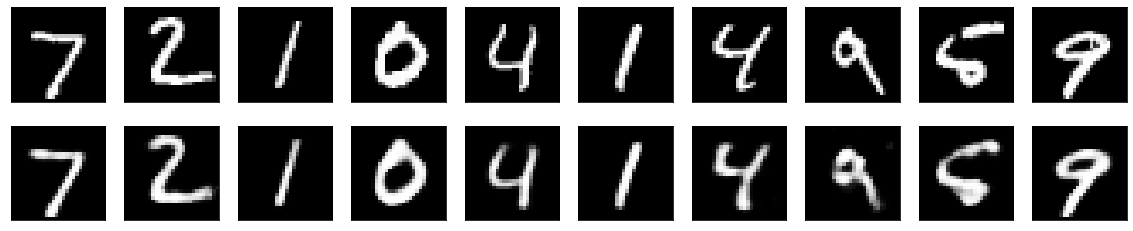

In [ ]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
def get_pair(model, base, pi_base):
    for layer in model.layers:
        if layer.name == base:
            dense = layer
        elif layer.name == pi_base:
            pi_dense = layer
        
    weights = dense.get_weights()
    print(len(weights))
    W = weights[0]
    print(type(W))
    print('W.shape', W.shape)
    # print('b.shape', b.shape)
    inv_weights = pi_dense.get_weights()
    print('inv_W.shape', inv_weights[0].shape)
    return W, inv_weights[0]

(a, inv_a) = get_pair(autoencoder, 'a', 'pi_a')
print(a.shape)
print(inv_a.shape)
gram = np.matmul(a, inv_a)
print(gram.shape)
print(np.linalg.det(gram))

(c, inv_c) = get_pair(autoencoder, 'c', 'pi_c')
print(c.shape)
print(inv_c.shape)
gram = np.matmul(inv_c, c)
print(gram.shape)
print(np.linalg.det(gram))

print(gram)

2
<class 'numpy.ndarray'>
W.shape (784, 128)
inv_W.shape (128, 784)
(784, 128)
(128, 784)
(784, 784)
0.0
2
<class 'numpy.ndarray'>
W.shape (64, 32)
inv_W.shape (32, 64)
(64, 32)
(32, 64)
(32, 32)
-28.12747
[[ 0.05150329 -0.15050215  0.51279116 ...  0.45988894  0.33783948
  -0.12213998]
 [-0.03733197 -0.353104    0.36968443 ...  0.6305652  -0.29074305
  -0.296542  ]
 [-0.24380706  0.15550894 -0.01287061 ... -0.5409992   0.3126014
  -0.29716858]
 ...
 [-0.2402599   0.43249375 -0.6957713  ... -0.1951999  -0.33454466
  -0.18841293]
 [ 0.08877896  0.06874514 -0.42993423 ...  0.41592747 -0.02911106
   0.3118027 ]
 [-0.23711295 -0.00164801  0.15618247 ...  0.30086982 -0.50485873
  -0.13383007]]
